In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from digen import Benchmark

sns.set()
sns.set_style("whitegrid")

In [2]:
with open("reduced_res.json") as f: 
    res_agg = json.load(f)
res_agg

{'feat': {'digen5_6949': {'dataset': 'digen5_6949',
   'classifier': {'pop_size': 460,
    'gens': 200,
    'ml': 'L1_LR',
    'classification': True,
    'verbosity': 0,
    'max_stall': 50,
    'sel': 'lexicase',
    'surv': 'nsga2',
    'cross_rate': 0.5,
    'root_xo_rate': 0.5,
    'otype': 'a',
    'functions': '',
    'max_depth': 5,
    'max_dim': 10,
    'random_state': 6949,
    'erc': False,
    'obj': 'fitness,size',
    'shuffle': True,
    'split': 0.75,
    'fb': 1,
    'scorer': 'log',
    'feature_names': '',
    'backprop': True,
    'iters': 1,
    'lr': 0.1,
    'batch_size': 0,
    'n_jobs': 1,
    'hillclimb': False,
    'logfile': '',
    'max_time': -1,
    'residual_xo': False,
    'stagewise_xo': True,
    'stagewise_xo_tol': False,
    'softmax_norm': False,
    'save_pop': 0,
    'normalize': False,
    'val_from_arch': True,
    'corr_delete_mutate': False,
    'simplify': 0.0,
    'protected_groups': '',
    'tune_initial': False,
    'tune_final': True,
 

In [3]:
algo_mapping = {
    'SymbolicClassifier': 'gplearn',
    'M3GP': 'M3GP',
    'ellyn': 'M4GP',
    'FeatClassifier': 'FEAT',
    'XGBClassifier': 'XGBoost',
    'LGBMClassifier': 'LightGBM',
    'GradientBoostingClassifier': "Gradient Boosting",
    'RandomForestClassifier': 'Random Forest',
    'DecisionTreeClassifier': "Decision Tree",
    'SVC': 'SVC',
    'LogisticRegression': 'Logistic Regression',
    'KNeighborsClassifier': "K-nearest Neighbors",
}

In [4]:

b = Benchmark()
df = b.data

gp_algos = ("gplearn", "M3GP", "ellyn", "feat")

for alg in gp_algos:
    new_results = res_agg[alg]
    z = pd.DataFrame.from_dict(new_results).transpose()
    z.drop('name', inplace=True)
    z['classifier'] = new_results['name']
    df = df.append(z)

df = df.pivot('classifier', columns='dataset', values='auroc')
df = df.transpose()
df.rename(columns=algo_mapping, inplace=True)
df = df[list(algo_mapping.values())]
df.index.rename("Datasets", inplace=True)
df.columns.rename("Algorithms", inplace=True)
df = df.astype(float).round(3)


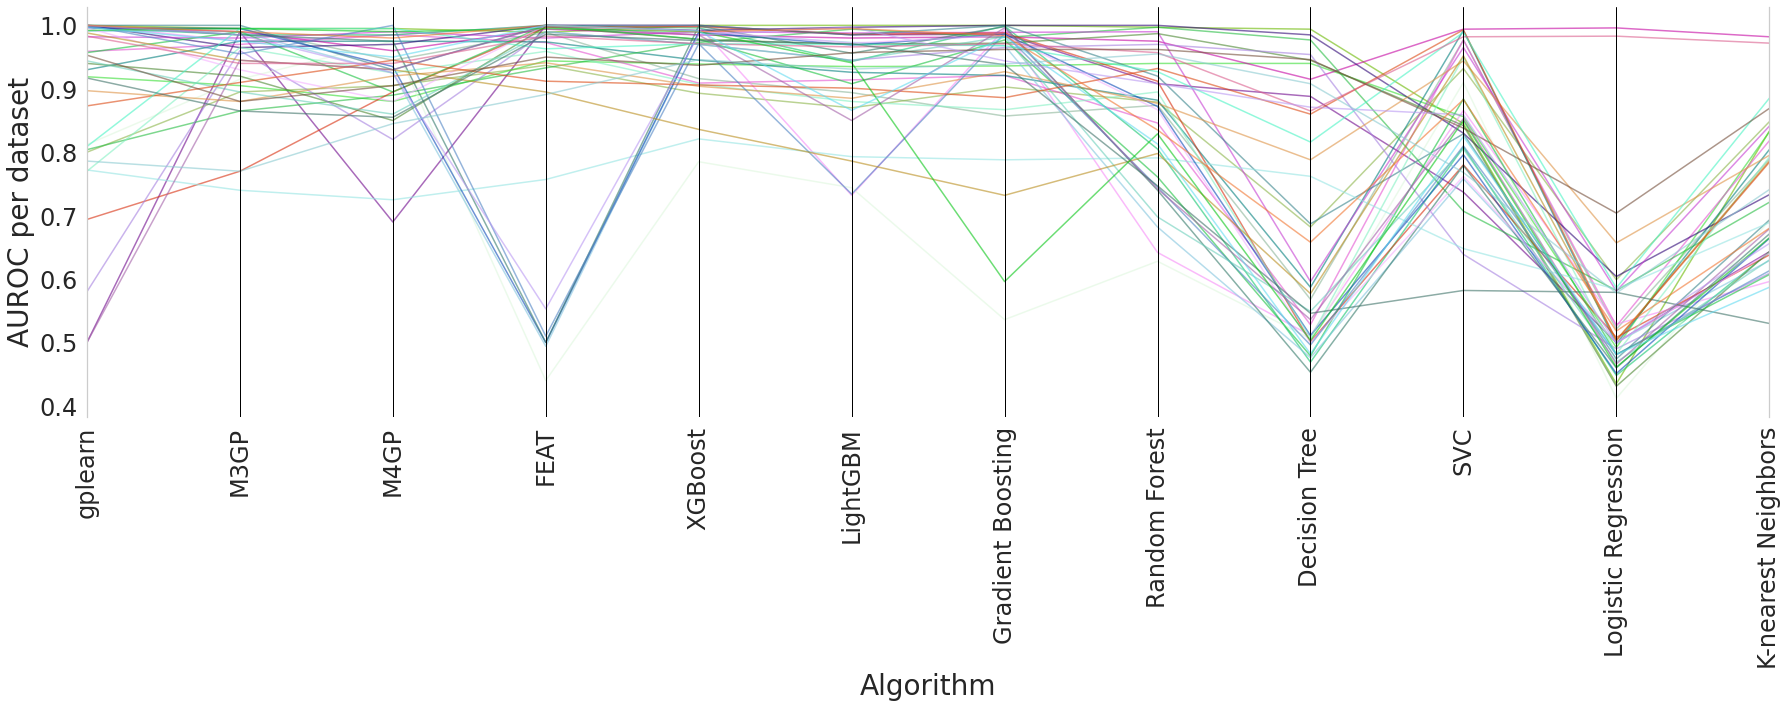

In [5]:
_, ax = plt.subplots(figsize=(25, 10))
df_ = df.copy()
df_["legend"] = df.index
pd.plotting.parallel_coordinates(df_, "legend", ax=ax, alpha=0.6)

ax.set_ylabel('AUROC per dataset', fontsize=28)

ax.set_xlabel("Algorithm", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)

plt.xticks(fontsize=24, rotation='vertical')
plt.yticks(fontsize=24)

plt.savefig("parallel_coordinates.pdf")

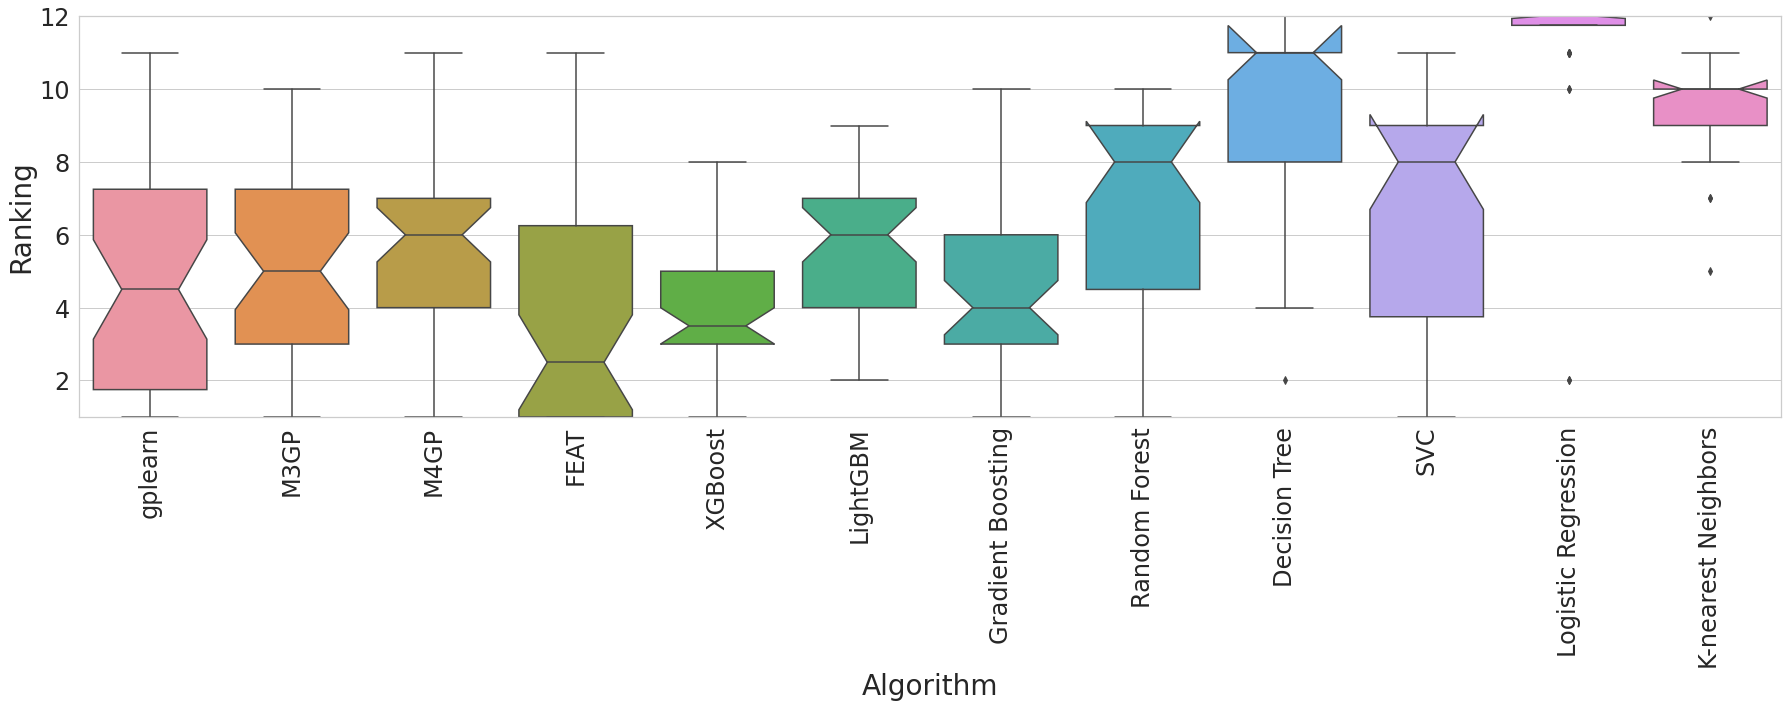

In [6]:
rank_df = (1 - df).rank(axis=1).astype(int)

plt.figure(figsize=(25, 10))
sns.boxplot(data=rank_df, notch=True)

plt.ylabel('Ranking', fontsize=28)
plt.xlabel('Algorithm', fontsize=28)
plt.xticks(fontsize=24, rotation='vertical')
plt.yticks(fontsize=24)
plt.ylim((1, rank_df.shape[1]))

plt.grid(True, axis='y')
plt.tight_layout()

plt.savefig("ranks.pdf")

/tmp/ipykernel_53894/3977953006.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig("clustermap.pdf")
/tmp/ipykernel_53894/3977953006.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig("clustermap.pdf")
/home/prenc/.conda/envs/digen/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


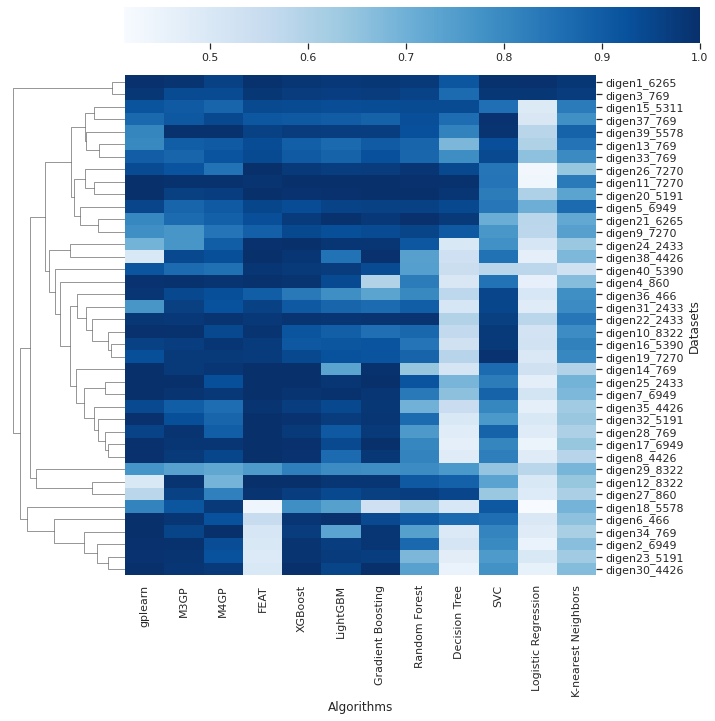

In [7]:
g = sns.clustermap(df, col_cluster=False, cmap="Blues",
                   dendrogram_ratio=(.2, .1),
                   cbar_pos=(.18, 0.95, .8, .05),
                   cbar_kws = dict(use_gridspec=False, orientation="horizontal"),
                   )
g.ax_col_dendrogram.set_visible(False)

plt.savefig("clustermap.pdf")

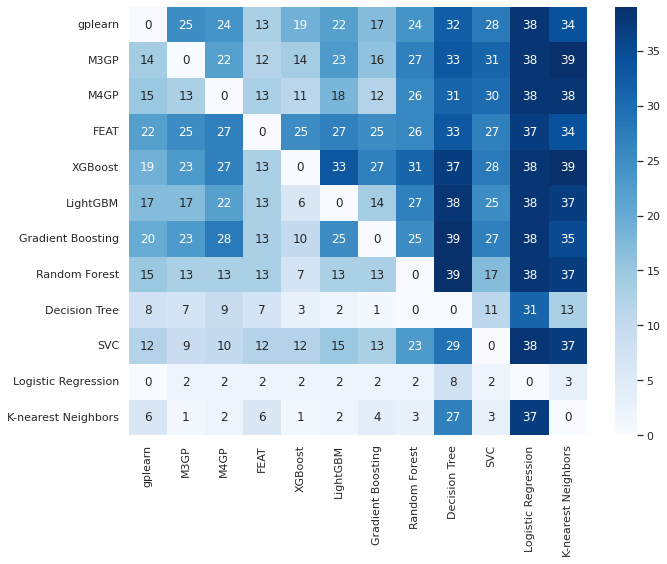

In [8]:
from itertools import product

algorithms = list(df.columns)
beat_df = pd.DataFrame(index=algorithms, columns=algorithms)

for alg1, alg2 in product(algorithms, algorithms):
    beat_df.loc[alg1, alg2] = (df[alg1] > df[alg2]).sum()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=beat_df.astype(int), annot=True, cmap="Blues")

plt.savefig("heatmap.pdf")